# Check The Math Behind the dE/dp Calculations

In [1]:
import numpy as np
from brian2 import *
from brian2tools import *
from sympy import *
from brian2.units.fundamentalunits import DIMENSIONLESS
from tqdm import tqdm

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Senstivity to Create The new system of Equations

In [2]:
def get_sensitivity_equations(group, parameters):
    eqs = group.equations
    diff_eqs = eqs.get_substituted_expressions(group.variables)
    diff_eq_names = [name for name, _ in diff_eqs]

    system = Matrix([diff_eq[1] for diff_eq in diff_eqs])
    J = system.jacobian(diff_eq_names)

    sensitivity = []
    sensitivity_names = []
    for parameter in parameters:
        F = system.jacobian([parameter])
        names = ['S_{}_{}'.format(diff_eq_name, parameter)
                 for diff_eq_name in diff_eq_names]
        sensitivity.append(J * Matrix(names) + F)
        sensitivity_names.append(names)

    new_eqs = []
    for names, sensitivity_eqs, param in zip(sensitivity_names, sensitivity, parameters):
        for name, eq, orig_var in zip(names, sensitivity_eqs, diff_eq_names):
            unit = eqs[orig_var].dim / group.namespace[parameter].dim
            new_eqs.append('d{lhs}/dt = {rhs} : {unit}'.format(lhs=name,
                                                           rhs=eq,
                                                           unit=repr(unit) if unit is not DIMENSIONLESS else '1'))
    new_eqs = Equations('\n'.join(new_eqs))
    return new_eqs

## Generate Sensitivity Equations for Conductivities

In [3]:
dt = 0.1 * ms
defaultclock.dt = dt
duration = 2*second

In [4]:
# Parameters
area = 20000*umetre**2
# gl = 5e-5*siemens*cm**-2 * area
# g_na = 100*msiemens*cm**-2 * area
# g_kd = 30*msiemens*cm**-2 * area
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

In [5]:
# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I) / Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I: amp 
'''
)

In [6]:
start_scope()

In [7]:
group = NeuronGroup(1, eqs,
                    method='exponential_euler',
                    namespace={'gl': 5e-5*siemens*cm**-2 * area,
                              'g_na': 100*msiemens*cm**-2 * area,
                              'g_kd': 30*msiemens*cm**-2 * area})
group.I = '1*nA'
group.v = El
mon = StateMonitor(group, ['v', 'I'], record=True)

In [8]:
run(20*ms)

In [9]:
output = mon.v

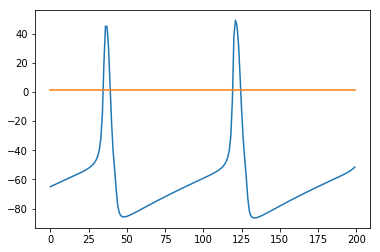

In [10]:
plt.plot(mon.v[0]/mV);
plt.plot(mon.I[0]/nA);

In [11]:
new_eqs = get_sensitivity_equations(group, ['gl', 'g_na', 'g_kd'])
new_eqs

dS_v_gl/dt = -S_h_gl*g_na*m**3.0*(-ENa + v)/Cm - 3.0*S_m_gl*g_na*h*m**2.0*(-ENa + v)/Cm - 4.0*S_n_gl*g_kd*n**3.0*(-EK + v)/Cm + S_v_gl*(-g_kd*n**4.0 - g_na*h*m**3.0 - gl)/Cm + (El - v)/Cm : metre ** 4 * kilogram ** 2 * second ** -6 * amp ** -3
dS_m_gl/dt = S_m_gl*(-0.32*mV**(-1.0)*(VT + 13.0*mV - v)/(ms*(exp((0.25*VT + 3.25*mV - 0.25*v)/mV) - 1.0)) - 0.28*mV**(-1.0)*(-VT - 40.0*mV + v)/(ms*(exp((-0.2*VT - 8.0*mV + 0.2*v)/mV) - 1.0))) + S_v_gl*(0.056*m*mV**(-2.0)*(exp((-0.2*VT - 8.0*mV + 0.2*v)/mV) - 1.0)**(-2.0)*(-VT - 40.0*mV + v)*exp((-0.2*VT - 8.0*mV + 0.2*v)/mV)/ms - 0.28*m*mV**(-1.0)/(ms*(exp((-0.2*VT - 8.0*mV + 0.2*v)/mV) - 1.0)) + 0.08*mV**(-2.0)*(1.0 - m)*(exp((0.25*VT + 3.25*mV - 0.25*v)/mV) - 1.0)**(-2.0)*(VT + 13.0*mV - v)*exp((0.25*VT + 3.25*mV - 0.25*v)/mV)/ms - 0.32*mV**(-1.0)*(1.0 - m)/(ms*(exp((0.25*VT + 3.25*mV - 0.25*v)/mV) - 1.0))) : ohm
dS_n_gl/dt = S_n_gl*(-0.032*mV**(-1.0)*(VT + 15.0*mV - v)/(ms*(exp((0.2*VT + 3.0*mV - 0.2*v)/mV) - 1.0)) - 0.5*exp((0.025*VT + 0.25

## Create Working Model to Plug in Variable Conductivity

In [12]:
# The model
eqs_fit = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I) / Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I: amp 
gl: siemens(constant)
g_na: siemens(constant)
g_kd: siemens(constant)
'''
)

In [13]:
t_start=0*second
n_samples = 1

In [14]:
model = eqs_fit + new_eqs

In [15]:
Ntraces, Nsteps = output.shape
duration = Nsteps * dt
output_traces = TimedArray(output.transpose(), dt=dt)
output_var = 'v'

In [16]:
start_scope()

In [17]:
neurons = NeuronGroup(1, model, method='exponential_euler',)
neurons.namespace['output_var'] = output_traces
neurons.namespace['Nsteps'] = Nsteps
neurons.namespace['Ntraces'] = Ntraces
neurons.namespace['t_start'] = t_start

In [18]:
d_gl = 5e-5*siemens*cm**-2 * area
d_g_na = 100*msiemens*cm**-2 * area
d_g_kd = 30*msiemens*cm**-2 * area

In [19]:
state = {'gl': d_gl, 'g_na': d_g_na, 'g_kd': d_g_kd}
neurons.set_states(state)

In [20]:
neurons.I = '1*nA'
neurons.v = El
mon = StateMonitor(neurons, ['v', 'S_v_gl','S_v_g_na', 'S_v_g_kd' ], record=True)

In [21]:
run(20*ms)

In [22]:
v_trace = mon.v[0]
svgl = mon.S_v_gl[0]
svgkd = mon.S_v_g_kd[0]
svgna = mon.S_v_g_na[0]

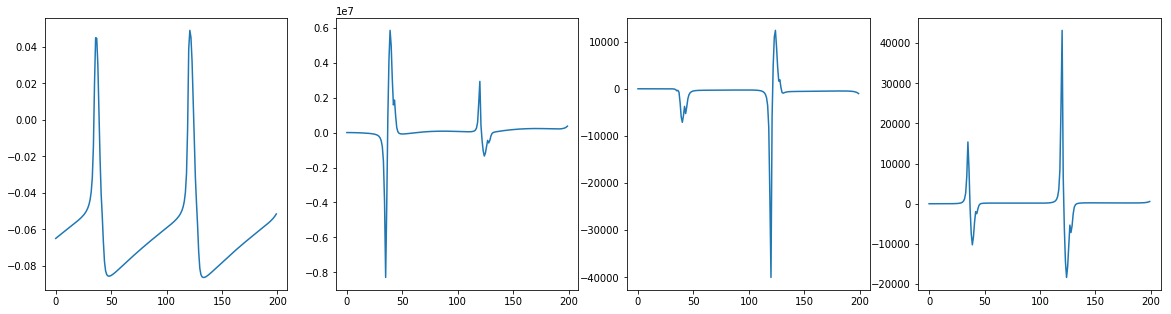

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,5))
ax[0].plot(v_trace)
ax[1].plot(svgl)
ax[2].plot(svgkd)
ax[3].plot(svgna)

In [24]:
data = output[0]

E = np.sum(np.square(data - v_trace))
dEdp = np.sum(2 * svgl * data - 2 * svgl * v_trace)

In [25]:
print(E, dEdp)

3.5031462 fV^2 -5.14913481e-08 m^6 kg^3 s^-9 A^-4


## Change it into a function

In [26]:
def eval_neurons(params):   
    # init neurons
    start_scope()
    neurons = NeuronGroup(1, model, method='exponential_euler',)
    neurons.namespace['output_var'] = output_traces
    neurons.namespace['Nsteps'] = Nsteps
    neurons.namespace['Ntraces'] = Ntraces
    neurons.namespace['t_start'] = t_start

    # set new parameters
    state = {'gl': params[0], 'g_na': params[1], 'g_kd': 6 * uS}
    neurons.set_states(state)

    # run simulation
    neurons.I = '1*nA'
    neurons.v = El
    mon = StateMonitor(neurons, ['v', 'S_v_gl','S_v_g_na', 'S_v_g_kd' ], record=True)
    run(20*ms)
    
    # get traces
    v_trace = mon.v[0]
    svgl = mon.S_v_gl[0]
    svgkd = mon.S_v_g_kd[0]
    svgna = mon.S_v_g_na[0]

    # analyze results
    dEdp = np.zeros(2) # ignore 3rd param for now
    data = output[0]

    E = np.sum(np.square(data - v_trace))/Nsteps
    dEdp[0] = np.sum(2 * svgl * (data - v_trace)) / Nsteps
    dEdp[1] = np.sum(2 * svgkd * (data - v_trace)) / Nsteps
    
    return E, dEdp

In [27]:
d = [10 * nS, 20 * uS]

In [28]:
a, b = eval_neurons(d)
b 

array([-4.59636386e-10, -3.37954512e-12])

## Vizualize 2D quiver of gradients

#### Every 0.5 s

In [29]:
param0 = np.arange(5, 15.1, 0.5)
param1 = np.arange(15, 25.1, 0.5)

In [30]:
X, Y, U, V = [], [], [], []

for p in tqdm(param0):
    for q in param1:
        X.append(p)
        Y.append(q)
        _, b = eval_neurons([p*nS,q*uS])
        U.append(b[0])
        V.append(b[1])

100%|██████████| 21/21 [01:32<00:00,  4.74s/it]


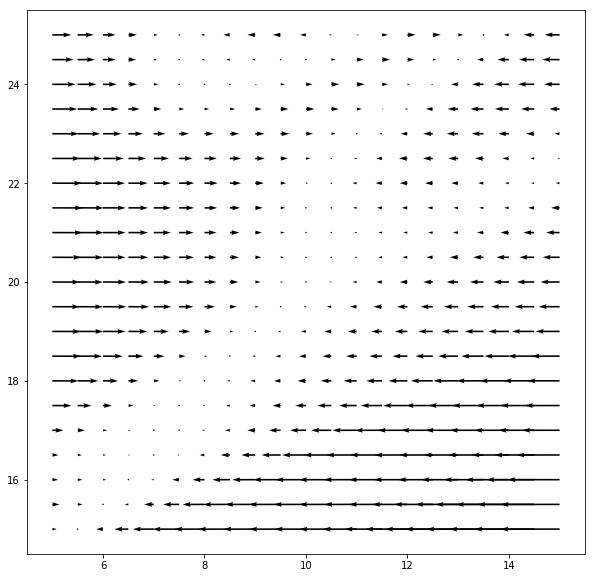

In [31]:
plt.figure(figsize=(10,10))
plt.quiver(X, Y, U, V);

In [32]:
# normalization attempt
# V_ = (V - np.min(V))/np.ptp(V)
# U_ = (U - np.min(U))/np.ptp(U)

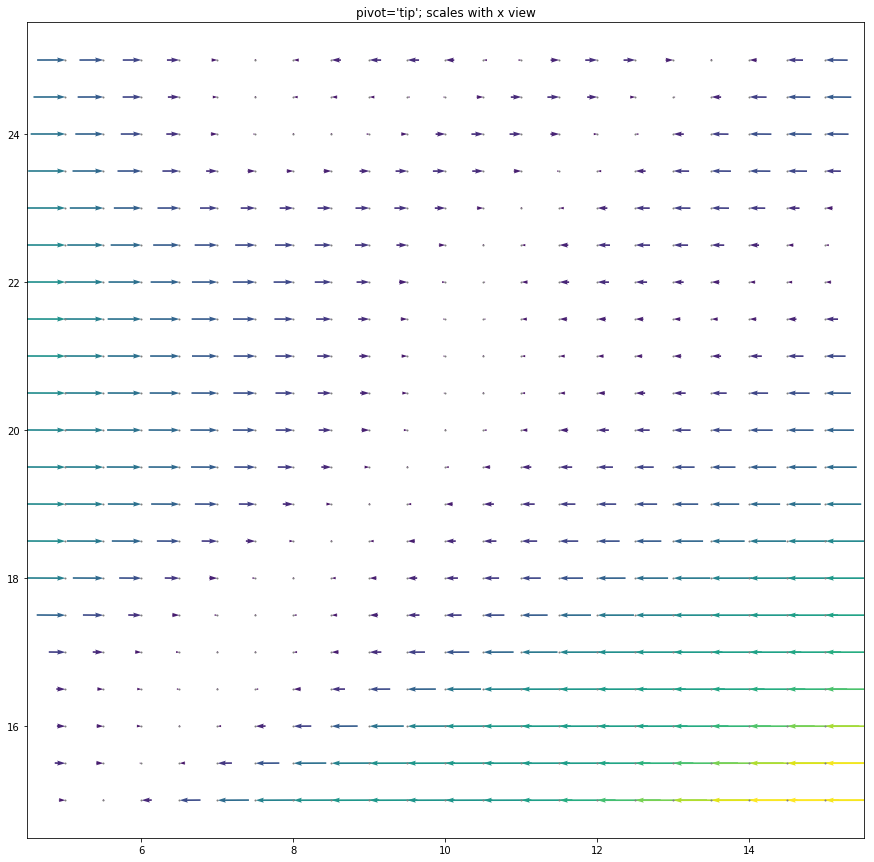

In [33]:
fig3, ax3 = plt.subplots(figsize=(15, 15))
ax3.set_title("pivot='tip'; scales with x view")
M = np.hypot(U, V)
ax3.quiver(X, Y, U, V, M, units='x', pivot='tip', width=0.022)
ax3.scatter(X, Y, color='0.5', s=1);


### Every 1 step

In [34]:
param0_1 = np.arange(5, 15.1, 1)
param1_1 = np.arange(15, 25.1, 1)

In [35]:
X_1, Y_1, U_1, V_1 = [], [], [], []

for p in tqdm(param0_1):
    for q in param1_1:
        X_1.append(p)
        Y_1.append(q)
        _, b = eval_neurons([p*nS,q*uS])
        U_1.append(b[0])
        V_1.append(b[1])

100%|██████████| 11/11 [00:23<00:00,  2.18s/it]


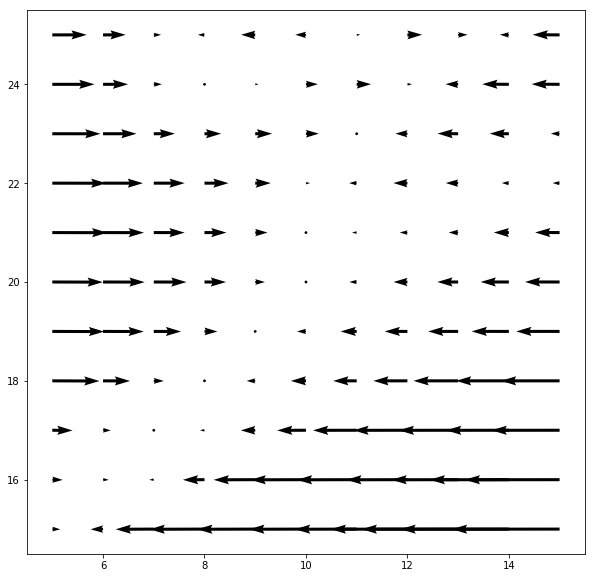

In [36]:
plt.figure(figsize=(10,10))
plt.quiver(X_1, Y_1, U_1, V_1);

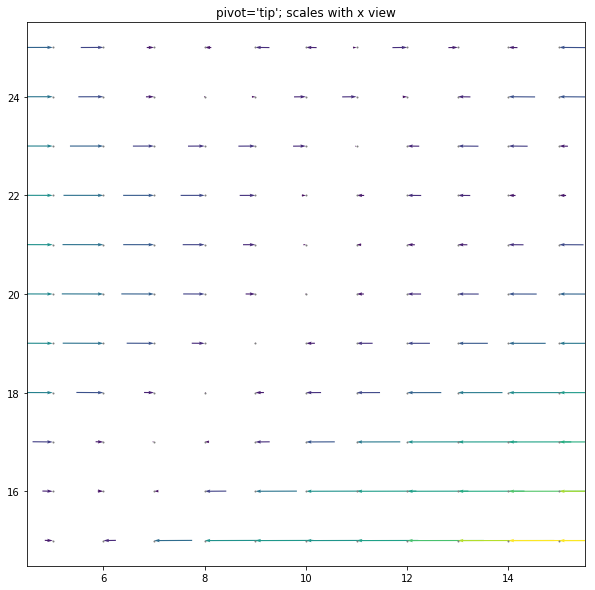

In [37]:
fig3, ax3 = plt.subplots(figsize=(10,10))
ax3.set_title("pivot='tip'; scales with x view")
M_1 = np.hypot(U_1, V_1)
ax3.quiver(X_1, Y_1, U_1, V_1, M_1, units='x', pivot='tip', width=0.022)
ax3.scatter(X_1, Y_1, color='0.5', s=1);


### Every 0.2 step

In [38]:
param0_02 = np.arange(5, 15.1, 0.2)
param1_02 = np.arange(15, 25.1, 0.2)

X_02, Y_02, U_02, V_02 = [], [], [], []

for p in tqdm(param0_02):
    for q in param1_02:
        X_02.append(p)
        Y_02.append(q)
        _, b = eval_neurons([p*nS,q*uS])
        U_02.append(b[0])
        V_02.append(b[1])

100%|██████████| 51/51 [11:05<00:00, 13.04s/it]


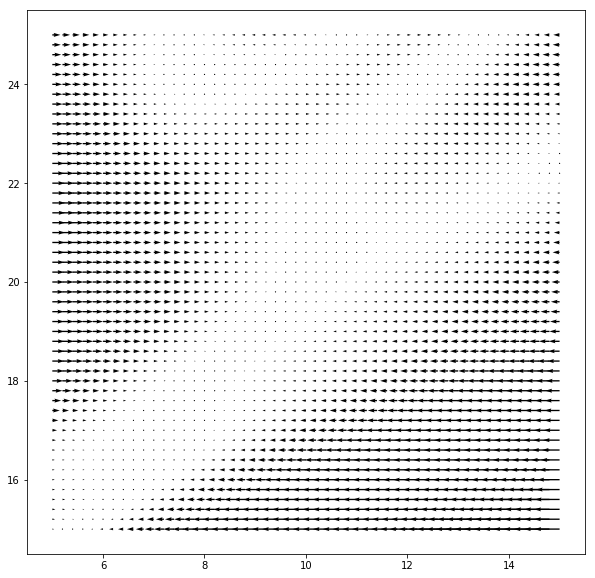

In [39]:
plt.figure(figsize=(10,10))
plt.quiver(X_02, Y_02, U_02, V_02);

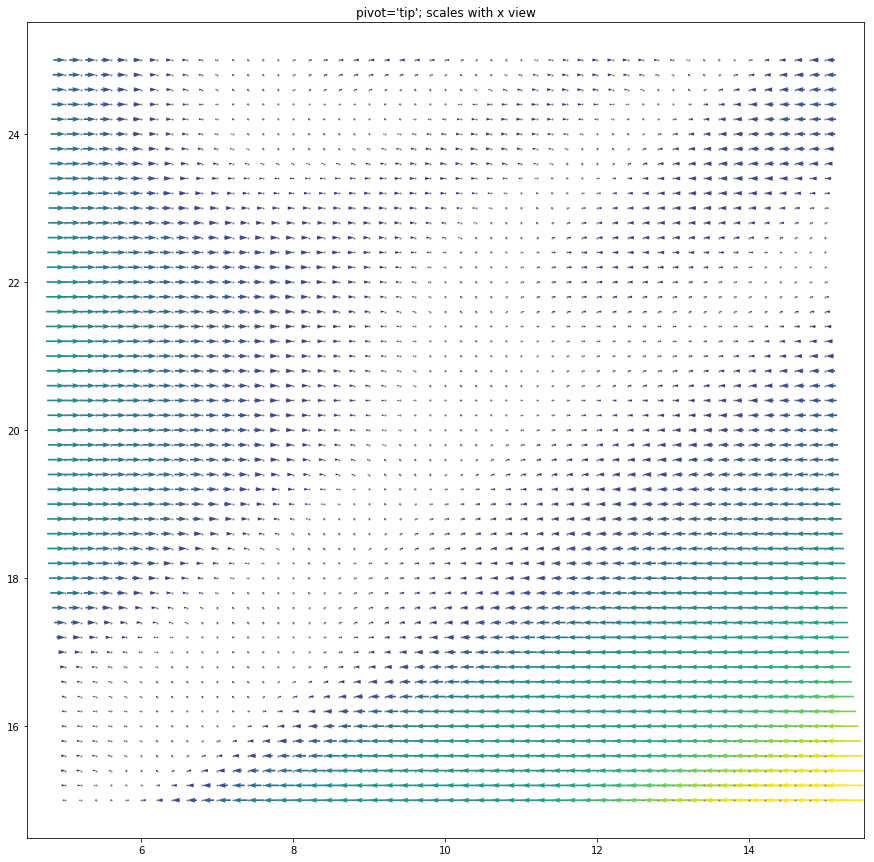

In [40]:
fig3, ax3 = plt.subplots(figsize=(15, 15))
ax3.set_title("pivot='tip'; scales with x view")
M_02 = np.hypot(U_02, V_02)
ax3.quiver(X_02, Y_02, U_02, V_02, M_02, units='x', pivot='tip', width=0.022)
ax3.scatter(X_02, Y_02, color='0.5', s=1);


### Smaller range 0.2 step

In [41]:
param0_02 = np.arange(8, 12.1, 0.2)
param1_02 = np.arange(18, 22.1, 0.2)

X_02, Y_02, U_02, V_02 = [], [], [], []

for p in tqdm(param0_02):
    for q in param1_02:
        X_02.append(p)
        Y_02.append(q)
        _, b = eval_neurons([p*nS,q*uS])
        U_02.append(b[0])
        V_02.append(b[1])

100%|██████████| 21/21 [01:55<00:00,  4.67s/it]


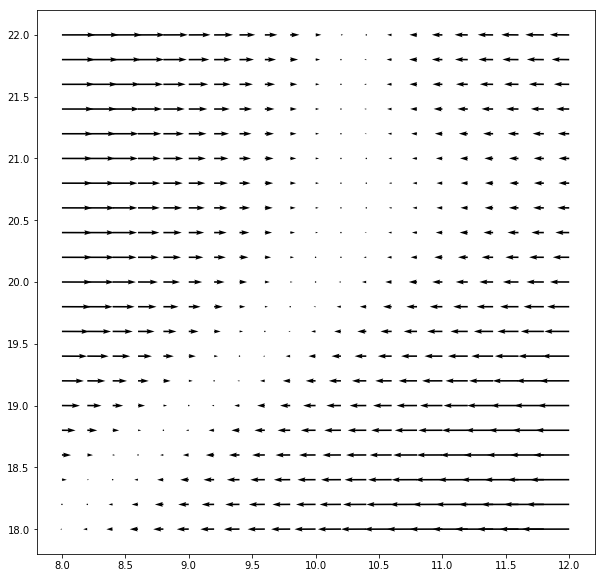

In [42]:
plt.figure(figsize=(10,10))
plt.quiver(X_02, Y_02, U_02, V_02);

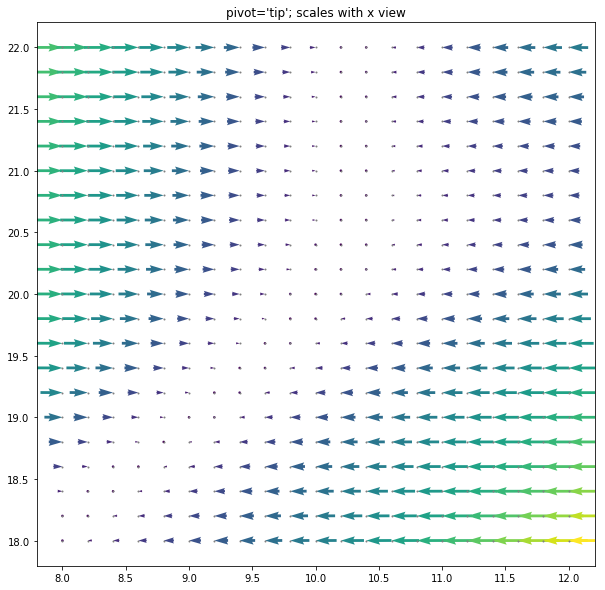

In [43]:
fig3, ax3 = plt.subplots(figsize=(10,10))
ax3.set_title("pivot='tip'; scales with x view")
M_02 = np.hypot(U_02, V_02)
ax3.quiver(X_02, Y_02, U_02, V_02, M_02, units='x', pivot='tip', width=0.022)
ax3.scatter(X_02, Y_02, color='0.5', s=1);


### Even Smaller range 0.1 step

In [44]:
param0_02 = np.arange(9, 11.1, 0.1)
param1_02 = np.arange(19, 21.1, 0.1)

X_02, Y_02, U_02, V_02 = [], [], [], []

for p in tqdm(param0_02):
    for q in param1_02:
        X_02.append(p)
        Y_02.append(q)
        _, b = eval_neurons([p*nS,q*uS])
        U_02.append(b[0])
        V_02.append(b[1])

100%|██████████| 21/21 [01:34<00:00,  4.40s/it]


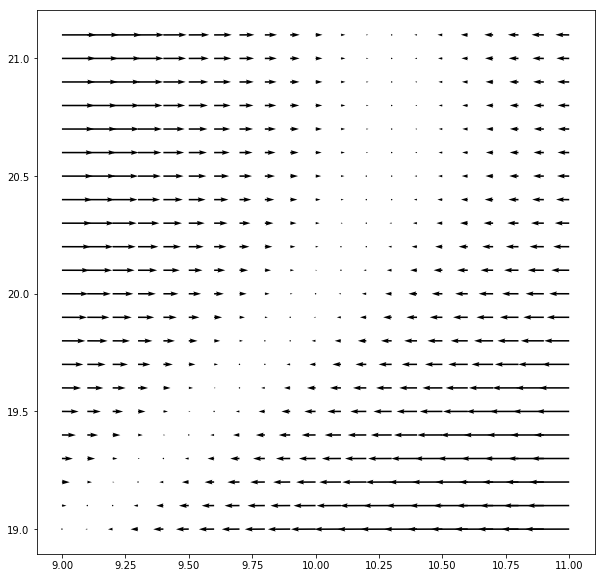

In [45]:
plt.figure(figsize=(10,10))
plt.quiver(X_02, Y_02, U_02, V_02);

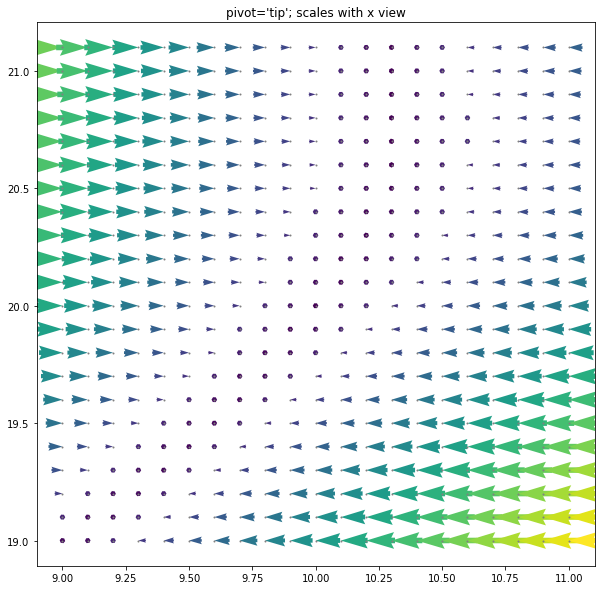

In [46]:
fig3, ax3 = plt.subplots(figsize=(10,10))
ax3.set_title("pivot='tip'; scales with x view")
M_02 = np.hypot(U_02, V_02)
ax3.quiver(X_02, Y_02, U_02, V_02, M_02, units='x', pivot='tip', width=0.022)
ax3.scatter(X_02, Y_02, color='0.5', s=1);


In [47]:
param0_02 = np.arange(9.5, 10.6, 0.05)
param1_02 = np.arange(19.5, 20.6, 0.05)

X_02, Y_02, U_02, V_02 = [], [], [], []

for p in tqdm(param0_02):
    for q in param1_02:
        X_02.append(p)
        Y_02.append(q)
        _, b = eval_neurons([p*nS,q*uS])
        U_02.append(b[0])
        V_02.append(b[1])

100%|██████████| 22/22 [01:59<00:00,  5.36s/it]


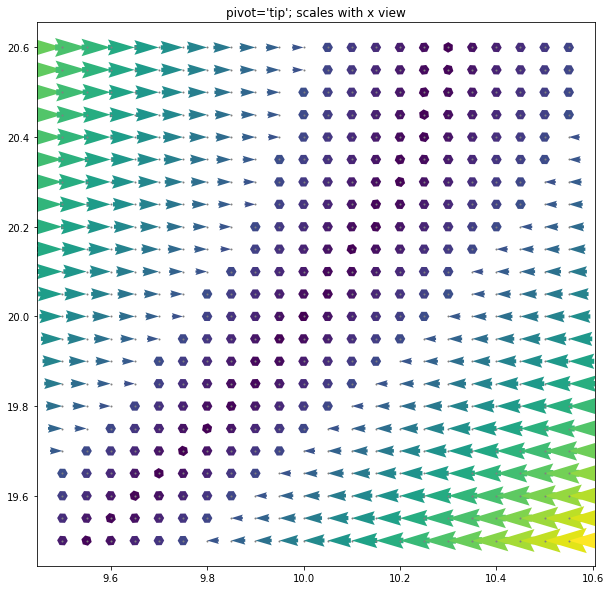

In [48]:
fig3, ax3 = plt.subplots(figsize=(10,10))
ax3.set_title("pivot='tip'; scales with x view")
M_02 = np.hypot(U_02, V_02)
ax3.quiver(X_02, Y_02, U_02, V_02, M_02, units='x', pivot='tip', width=0.022)
ax3.scatter(X_02, Y_02, color='0.5', s=1);


In [ ]:
X_02, Y_02, U_02, V_02

In [1]:
X_02_ = X_02[200:400]
# Y_02, U_02, V_02

NameError: name 'X_02' is not defined